In [1]:
%load_ext autoreload
%autoreload 2

import sys
# change this to suit your path
sys.path.append('/home/guillaume/Python/kt_simul/')
from kt_simul.smp_spindle.smp_spindle import SympySpindle, parameters


import IPython.display as disp
import os

ImportError: bad magic number in 'kt_simul.smp_spindle': b'\x03\xf3\r\n'

### Visualisation using openscad

This has the advangtage of being simple to use

```python
import solid as solid
import tempfile
solid.use('spindle.scad')
spindle_length = 4
ch_pos = [-0.4, 0.1, 1]
stretch = 0.3
ch_theta = 30
ch_phi = 10

scad_spindle = (spindle_midzone(spindle_length) +
                chromosome(ch_pos, stretch, ch_theta, ch_phi))
def show_scad(scad_spindle, img_name='spindle_scad.png'):
    if os.path.isfile(img_name):
        os.remove(img_name)
    with tempfile.NamedTemporaryFile('w', suffix='.scad') as tmp_scad:
        solid.scad_render_to_file(scad_spindle, tmp_scad.name)
        os.system('openscad -o {} {}'.format(img_name, tmp_scad.name))
    return disp.Image(img_name)
show_scad(scad_spindle)
```

In [2]:
from sympy.physics.mechanics import mechanics_printing

mechanics_printing(pretty_print=True)  # Shinny


In [3]:
import vispy.geometry as vp_geom
import vispy.util as vp_util

def translate(mesh, pos):
    
    mesh.set_vertices(mesh.get_vertices() + pos)
    return mesh
    

def create_spb(pos, radius=0.3):
    spb = vp_geom.create_sphere(12, 12, radius)
    return translate(spb, pos)
    
    
def create_midzone(length, r=0.2):
    
    mz = vp_geom.create_cylinder(12, 2, [r, r],
                                 length, True)
    return mz
    
def create_chromosome(stretch, orientation, r=0.1):
    
    theta, phi, omega = orientation
    
    ch = vp_geom.create_cylinder(12, 2, [r, r],
                                 length, True)
    
### Maybe scene visuals is better suited, see:
### http://api.vispy.org/en/latest/scene.html

from vispy import app, gloo, visuals

class Canvas(app.Canvas):
    def __init__(self, mdatas):
        app.Canvas.__init__(self, keys='interactive', size=(800, 550))

        self.rotation = AffineTransform()
        self.meshes = [visuals.MeshVisual(meshdata=mdata, color='r') for mdata in mdatas]

        self.show()

        self.timer = app.Timer(connect=self.rotate)
        self.timer.start(0.016)

    def rotate(self, event):
        self.rotation.rotate(1, (0, 1, 0))
        self.update()

    def on_draw(self, ev):
        gloo.set_viewport(0, 0, *self.physical_size)
        gloo.clear(color='black', depth=True)
        for mesh in self.meshes:
            mesh.draw()

length = 3.

            
spbL = create_spb([-length/2, 0, 0])
spbR = create_spb([length/2, 0, 0])
mz = create_midzone(length)

#win = Canvas([spbL, spbR, mz])
#import sys a
#if sys.flags.interactive != 1:
#    app.run()

### Too be continued    



### Model description

We're looking at a simple mechanical system

![3D spindle](3d_spindle.svg)



#### Points and coordiantes

Point is the physical location of an element.

In the method we use to write the equations of motion of the system, we use what is caled **generalized coordinates** and **generalized speeds**. The generic letter for a gen. coordinate is **q** and **u** for the speeds. Those are the quantities marked in red on the sketch.

As a starting point to a 3D description of the spindle, we assume that the chromosomes are 'aligned', thus there is a single extra reference frame, noted $\mathbf{C}$, for each chromosome.




### Parameters 

In [4]:
## Those are simple  `sympy.symbols`
for param in parameters.keys():
    print(param)

F_k
V_mz
mu_ch
mu_c
mu_s
kappa_k
kappa_c
F_mz
V_k
d_0
mu_k


## Spindle class instanciation



In [11]:
spindle = SympySpindle('3D_1_1', N=1, Mk=1)

$$\frac{d}{dt}\left(d_{ij}\frac{r_{ij}}{d_{ij}}\right)$$

In [12]:
spindle.u_ind

In [13]:
spindle.q_ind

In [14]:
ch = spindle.chromosomes[0]

In [15]:
ps = ch.cen_A.plugsites[0]

In [16]:
cen_A00 = spindle.points[3]

In [17]:
spindle.kanesmethod()

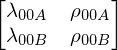

In [18]:
spindle.attach_state

In [19]:
import sympy as sy
from sympy import sympify, lambdify


In [20]:
amphitelic = {astate:val for astate, val in zip(spindle.attach_state, sy.Identity(2))}

In [21]:
passive_params = ['mu_s', 'mu_ch', 'mu_c','mu_k',
                  'kappa_c', 'kappa_k', 'd_0']
passive_zero = {parameters[name]:0 for name in passive_params}

active_params = ['F_k', 'V_k', 'F_mz', 'V_mz']
active_zero = {parameters[name]:0 for name in active_params}

adim = {parameters['F_k']:1, parameters['V_k']:1}

In [22]:
A0 = spindle.A_uu.subs(active_zero).subs(adim)
At = spindle.A_uu.subs(passive_zero).subs(adim)
At_args = [parameters[name] for name in active_params] + list(spindle.attach_state)
A0_args = [parameters[name] for name in passive_params]

In [23]:
import sympy as sy

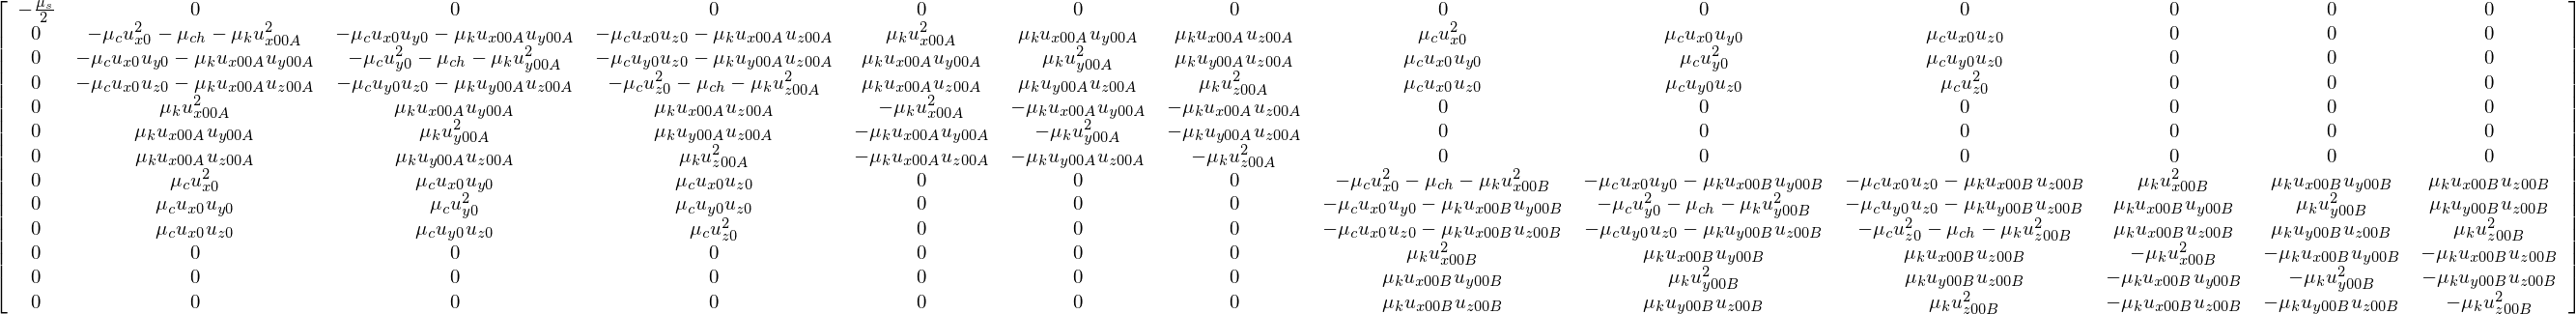

In [24]:
A0

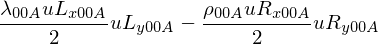

In [25]:
At[5]

In [30]:
speed_0 = {u:0 for u in spindle.u_ind}

In [31]:
B = spindle.eoms.subs(speed_0)

In [35]:
spindle.eoms[1]

In [47]:
At_args

In [18]:
spindle.q_ind

[L, x_0, y_0, theta_0, l_0, d_00^A, d_00^B]

In [39]:
import pandas as pd
import numpy as np

In [37]:
parameters

{'F_k': F_k,
 'F_mz': F_mz,
 'V_k': V_k,
 'V_mz': V_mz,
 'd_0': d_0,
 'kappa_c': kappa_c,
 'kappa_k': kappa_k,
 'mu_c': mu_c,
 'mu_ch': mu_ch,
 'mu_k': mu_k,
 'mu_s': mu_s}

In [56]:
coords = ['x', 'y', 'z']
speed_coords = ['v'+c for c in coords]
point_cols = coords + speed_coords

class Structure:
    
    def __init__(self, name):
        self.name = name
        self.points = {}
        self.point_df = pd.DataFrame(columns=point_cols)

    def add_point(self, idx, pos0=None, speed0=None):
        
        if pos0 is None:
            pos0 = np.zeros(len(coords))
        if speed0 is None:
            speed0 = np.zeros(len(coords))
        
        state = np.concatenate((pos0, speed0)).reshape((1, len(coords)*2))
        self.point_df = self.point_df.append(pd.DataFrame(index=[idx,],
                                                          data=state,
                                                          columns=point_cols))
        p = Point(idx, self)
        self.points[idx] = p
        return p

class Point:
    
    def __init__(self, idx, structure):
        
        self.idx = idx
        self.structure = structure
        
    @property
    def pos(self):
        return self.structure.point_df.loc[self.idx, coords]

    @property
    def speed(self):
        return self.structure.point_df.loc[self.idx, speed_coords]
    
            
class Link:
    
    def __init__(self, point_i, point_j, structure):
        self.idx = (point_i.idx, point_j.idx)


        
spindle = Structure('df_spindle_1_1')

        
spbL = spindle.add_point(0, [-1, 0, 0])
spbR = spindle.add_point(1, [1, 0, 0])
cenA = spindle.add_point(2, [-0.2, 0, 0])
cenB = spindle.add_point(3, [0.2, 0, 0])

psA = spindle.add_point(4, [-0.3, 0, 0])
psB = spindle.add_point(5, [0.3, 0, 0])




In [58]:
spbL.speed

vx    0
vy    0
vz    0
Name: 0, dtype: float64

In [48]:

point_df.append()

,x,y,z,vx,vy,vz
idx,,,,,,
0,-1,0,0,0,0,0
1,1,0,0,0,0,0
2,-0.2,0,0,0,0,0
3,0.2,0,0,0,0,0
4,-0.3,0,0,0,0,0
5,0.3,0,0,0,0,0
6,0,0,0,0,0,0


In [28]:


At_np = lambdify(At_args, At, 'numpy', dummify=False)
A0_np = lambdify(A0_args, A0, 'numpy', dummify=False)

In [21]:
import numpy as np

In [24]:
np.linalg.norm(np.array((1, 2, 3)) - np.array((4, 5, 6)))

5.19615242271

In [44]:
A0_np()

<function numpy.<lambda>>

In [28]:
At_np(1, 1, 5, 1, 1, 0, 1, 0)

matrix([[-5.5,  0. ,  0. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. , -0.5,
          0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ],
        [-0.5,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ],
        [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
          0. ,  0. ],
        [-0.5,  0. ,  0. ,  0.

In [36]:
spindle.q_ind

[L, x_0A, y_0A, z_0A, x_00A, y_00A, z_00A, x_0B, y_0B, z_0B, x_00B, y_00B, z_00B]

In [35]:
spindle.KM.forcelist[-1][1]

- mu_c*(-vx_0A + vx_0B)*S.x - mu_c*(-vy_0A + vy_0B)*S.y - mu_c*(-vz_0A + vz_0B)*S.z

In [37]:
A0

Matrix([
[-mu_s/2,                    0,                    0,                    0,     0,     0,     0,                    0,                    0,                    0,     0,     0,     0],
[      0, -mu_c - mu_ch - mu_k,                    0,                    0,  mu_k,     0,     0,                 mu_c,                    0,                    0,     0,     0,     0],
[      0,                    0, -mu_c - mu_ch - mu_k,                    0,     0,  mu_k,     0,                    0,                 mu_c,                    0,     0,     0,     0],
[      0,                    0,                    0, -mu_c - mu_ch - mu_k,     0,     0,  mu_k,                    0,                    0,                 mu_c,     0,     0,     0],
[      0,                 mu_k,                    0,                    0, -mu_k,     0,     0,                    0,                    0,                    0,     0,     0,     0],
[      0,                    0,                 mu_k,             

In [43]:
from kt_simul.io.parameters_io import ParamTree
from kt_simul.core.simul_spindle import Metaphase